In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('metrics.csv')

print(data.head())

         instance            timestamp metric_name     value
0  localhost:9100  2024-12-02 17:38:31   cpu_usage  3.272218
1  localhost:9100  2024-12-02 17:38:36   cpu_usage  3.272218
2  localhost:9100  2024-12-03 17:38:36   cpu_usage  3.272218
3  localhost:9100  2024-12-04 17:47:15   cpu_usage  3.556889
4  localhost:9100  2024-12-04 17:55:35   cpu_usage  3.485778


Check for missing or duplicate rows

In [4]:
# Check column types and data info
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Check for duplicates
print()
print('duplicated values:', data.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   instance     102 non-null    object 
 1   timestamp    102 non-null    object 
 2   metric_name  102 non-null    object 
 3   value        102 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
instance       0
timestamp      0
metric_name    0
value          0
dtype: int64

duplicated values: 0


Convert timestamp to Datetime

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
# Extract time-based features
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # monday=0, sunday=6


In [7]:
print(data[['timestamp', 'hour', 'day_of_week', 'is_weekend']].head())


            timestamp  hour  day_of_week  is_weekend
0 2024-12-02 17:38:31    17            0           0
1 2024-12-02 17:38:36    17            0           0
2 2024-12-03 17:38:36    17            1           0
3 2024-12-04 17:47:15    17            2           0
4 2024-12-04 17:55:35    17            2           0


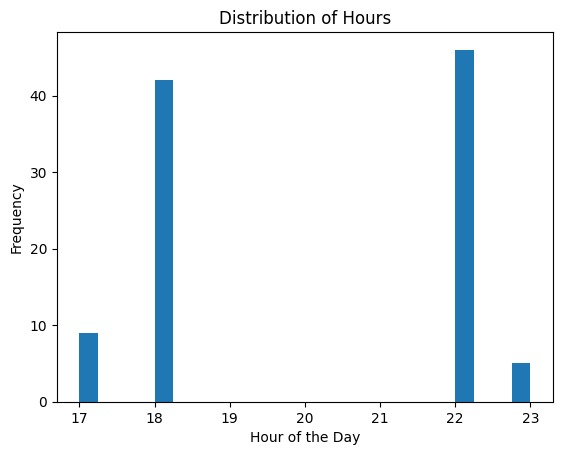

In [8]:
import matplotlib.pyplot as plt

data['hour'].hist(bins=24, grid=False)
plt.title('Distribution of Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()


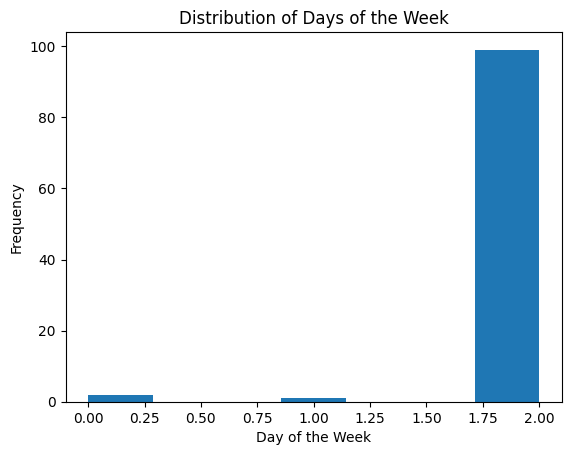

In [15]:
data['day_of_week'].hist(bins=7, grid=False)
plt.title('Distribution of Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.show()

 Normalize the value Column
 Using the MinMaxScaler from scikit-learn, we can normalize the value column to a range between 0 and 1.

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data["scaled_value"] = scaler.fit_transform(data[["value"]])

print(data[['value', 'scaled_value']].head())



      value  scaled_value
0  3.272218      0.400540
1  3.272218      0.400540
2  3.272218      0.400540
3  3.556889      0.580026
4  3.485778      0.535190
0.0 1.0


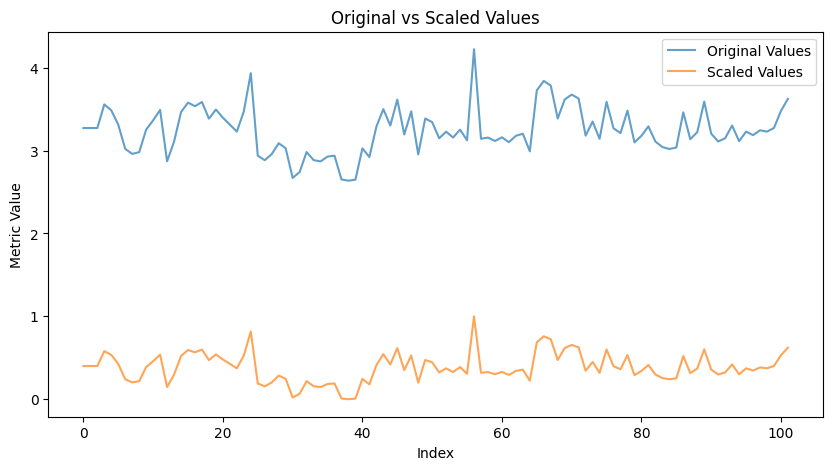

In [14]:
plt.figure(figsize=(10, 5))

# Original values
plt.plot(data['value'], label='Original Values', alpha=0.7)

# Scaled values
plt.plot(data['scaled_value'], label='Scaled Values', alpha=0.7)

plt.legend()
plt.title('Original vs Scaled Values')
plt.xlabel('Index')
plt.ylabel('Metric Value')
plt.show()